<a href="https://colab.research.google.com/github/iitianpushkar/Schrodinger_PINN_Solution_PyTorch/blob/main/Schrodinger_PINN_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [100/2000], NN Loss: 0.125542, PINN Loss: 0.247668
Epoch [200/2000], NN Loss: 0.011753, PINN Loss: 0.030415
Epoch [300/2000], NN Loss: 0.001988, PINN Loss: 0.012434
Epoch [400/2000], NN Loss: 0.000602, PINN Loss: 0.010972
Epoch [500/2000], NN Loss: 0.000245, PINN Loss: 0.010672
Epoch [600/2000], NN Loss: 0.000117, PINN Loss: 0.010471
Epoch [700/2000], NN Loss: 0.000063, PINN Loss: 0.010305
Epoch [800/2000], NN Loss: 0.000039, PINN Loss: 0.010175
Epoch [900/2000], NN Loss: 0.000026, PINN Loss: 0.010077
Epoch [1000/2000], NN Loss: 0.000019, PINN Loss: 0.010004
Epoch [1100/2000], NN Loss: 0.000016, PINN Loss: 0.009949
Epoch [1200/2000], NN Loss: 0.000013, PINN Loss: 0.009909
Epoch [1300/2000], NN Loss: 0.000012, PINN Loss: 0.009880
Epoch [1400/2000], NN Loss: 0.000011, PINN Loss: 0.009860
Epoch [1500/2000], NN Loss: 0.000011, PINN Loss: 0.009845
Epoch [1600/2000], NN Loss: 0.000010, PINN Loss: 0.009836
Epoch [1700/2000], NN Loss: 0.000010, PINN Loss: 0.009830
Epoch [1800/2000], NN L

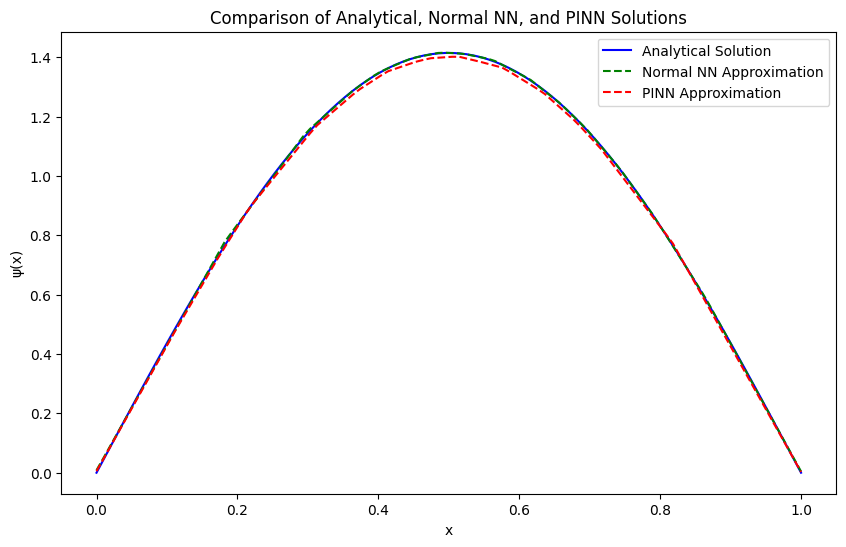

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define constants
hbar = 1.0
m = 1.0
L = 1.0  # Length of the box
alpha = 1e-2  # Weight for PINN loss term
beta = 1e-1   # Weight for boundary condition term

# Discretize the spatial domain
x = np.linspace(0, L, 100).reshape(-1, 1)
x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)  # Enable gradient calculation for x

# Define the analytical solution (ground state)
def psi_analytical(x):
    return np.sqrt(2/L) * np.sin(np.pi * x / L)

y_train = psi_analytical(x)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

# Neural network model for PINN
class SchrodingerNN(nn.Module):
    def __init__(self):
        super(SchrodingerNN, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Schrodinger equation residual for PINN
def schrodinger_residual(x, psi_pred):
    psi_x = torch.autograd.grad(psi_pred, x, grad_outputs=torch.ones_like(psi_pred), create_graph=True)[0]
    psi_xx = torch.autograd.grad(psi_x, x, grad_outputs=torch.ones_like(psi_x), create_graph=True)[0]
    residual = -(hbar**2 / (2 * m)) * psi_xx - psi_pred  # Time-independent Schrodinger equation for 1D particle in a box
    return residual

# Initialize model, loss function, and optimizer for PINN
pinn_model = SchrodingerNN()
pinn_optimizer = optim.Adam(pinn_model.parameters(), lr=0.001)

# Initialize model, loss function, and optimizer for Normal NN
nn_model = SchrodingerNN()
nn_optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
nn_criterion = nn.MSELoss()

# Training loop for both PINN and Normal NN
epochs = 2000
for epoch in range(epochs):
    # Training for Normal NN
    nn_optimizer.zero_grad()
    nn_outputs = nn_model(x_tensor)
    nn_loss = nn_criterion(nn_outputs, y_tensor)
    nn_loss.backward()
    nn_optimizer.step()

    # Training for PINN
    pinn_optimizer.zero_grad()

    # Compute predictions
    psi_pred = pinn_model(x_tensor)

    # Schrodinger residual loss
    residual = schrodinger_residual(x_tensor, psi_pred)
    pinn_loss = torch.mean(residual**2)

    # Boundary condition loss
    psi_0 = pinn_model(torch.tensor([[0.0]], dtype=torch.float32))
    psi_L = pinn_model(torch.tensor([[L]], dtype=torch.float32))
    bc_loss = torch.mean(psi_0**2 + psi_L**2)

    # Data loss (comparison to analytical solution)
    data_loss = torch.mean((psi_pred - y_tensor)**2)

    # Total loss for PINN
    total_pinn_loss = alpha * pinn_loss + beta * bc_loss + data_loss

    # Backpropagation and optimization for PINN
    total_pinn_loss.backward()
    pinn_optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], NN Loss: {nn_loss.item():.6f}, PINN Loss: {total_pinn_loss.item():.6f}")

# Prediction using the trained Normal NN model
y_pred_nn = nn_model(x_tensor).detach().numpy()

# Prediction using the trained PINN model
y_pred_pinn = pinn_model(x_tensor).detach().numpy()

# Plotting the results for comparison
plt.figure(figsize=(10, 6))
plt.plot(x, y_train, label="Analytical Solution", color='blue')
plt.plot(x, y_pred_nn, label="Normal NN Approximation", color='green', linestyle='--')
plt.plot(x, y_pred_pinn, label="PINN Approximation", color='red', linestyle='--')
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.title("Comparison of Analytical, Normal NN, and PINN Solutions")
plt.legend()
plt.show()
